In [1]:
from src.chinese_checkers.experience import ExperienceGenerator, IRewardStrategy, RewardStrategyFactory
from src.chinese_checkers.encoder import ExperienceEncoder, MoveEncoder

from src.chinese_checkers.model import BootstrapModel

from typing import List

from src.chinese_checkers.simulation import GameSimulationCatalog

from src.chinese_checkers.dql import DQLAgent, DqlModel
from src.chinese_checkers.simulation import GameSimulation


# DQL Module Examples

---

## Example 1: Train the model on simulation data

In [2]:
catalog = GameSimulationCatalog("D:/chinese_checkers_games")
metadata_list = catalog.list_available_metadata()
simulations = list(catalog.load_simulations_by_metadata(metadata_list[0]))

print(f"Loaded {len(simulations)} simulations")

# use the distance to win reward strategy
reward_strategy: IRewardStrategy = RewardStrategyFactory.create("distance_to_win")
experience_generator = ExperienceGenerator(reward_strategy)
encoder = ExperienceEncoder(
    game_encoder="grid_position_target",
    max_moves=100
)

# create new experiences from the simulations
experiences: List[any] = [
    encoder.encode(exper)
    for sim in simulations
    for exper in experience_generator.generate_experiences_from_simulation(sim)
]

Loaded 23 simulations


In [ ]:
state_dim = experiences[0][0].shape[0]
model_save_path = "dlq_agent_model_v001.pth"


In [5]:
import torch
from tqdm import tqdm

# Determine state and move dimensions
move_dim = MoveEncoder.MOVE_DIM  # Fixed move encoding dimension
batch_size = 64  # Define batch size for training

# Initialize the DQL agent
agent = DQLAgent(state_dim=state_dim, move_dim=move_dim, batch_size=batch_size)
print(f"Model initialized with state_dim={state_dim} and move_dim={move_dim}")

# Add all experiences to the replay buffer
for e in experiences:
    agent.store_experience(e)

# Training loop with batch processing
num_batches = len(experiences) // batch_size  # Number of batches in the dataset
for _ in tqdm(range(num_batches), desc="Training DQL Agent", unit="batch"):
    try:
        # Run the training step (it samples from the replay buffer within `train`)
        agent.train()

    except Exception as ex:
        print(f"Error encountered during batch training: {ex}")
        raise

# Save the trained model to a file
torch.save(agent.q_network.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model initialized with state_dim=984 and move_dim=4


Training DQL Agent: 100%|██████████| 111/111 [00:37<00:00,  2.96batch/s]

Model saved to trained_dql_model.pth


In [6]:
model_1 = BootstrapModel()
model_2 = DqlModel(model_save_path, encoder, state_dim=state_dim, action_dim=MoveEncoder.MOVE_DIM)
game_simulation = GameSimulation.simulate_game(
    models=[model_1, model_2],
    name="bootstrap-simulation",
    version="v0.0.1",
    print_period=40,
    show_coordinates=True,
    max_turns=10000
)

Model loaded successfully from trained_dql_model.pth


Creating Animation:   0%|          | 0/63 [00:00<?, ?it/s]


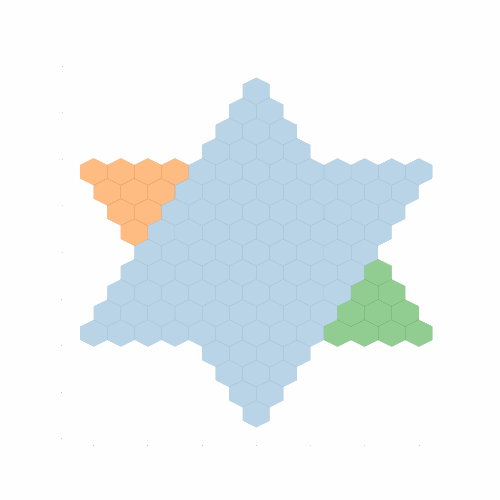

In [7]:
game_simulation.display()


In [8]:
mp3_save_path = model_save_path.replace(".pth", ".mp4")
game_simulation.save_animation(mp3_save_path)

Creating Animation:   0%|          | 0/63 [00:00<?, ?it/s]
